In [1]:
import numpy as np
import scipy
import matplotlib as mpl
from matplotlib import pyplot as plt
plt.rcParams['pdf.fonttype'] = 42

import torch
import torchvision
from torch import nn, optim
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from scipy.io import loadmat
import os, sys
import torchvision.transforms as transforms
import string
from  collections import defaultdict
from sklearn.linear_model import LassoCV
from scipy import stats

# images = loadmat('baoimg.mat').get('img')
%run clean_cornets.py

In [2]:
from torchvision import datasets, transforms

# data_dir = 'images/'
data_dir = 'stimuli/wordsets_1000cat_8ex/'
transform = {'train': transforms.Compose([transforms.Resize((224,224)),
transforms.ToTensor(),
transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])]),}

chosen_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), transform =  transform[x]) for x in ['train']}
dataloaders = {x: torch.utils.data.DataLoader(chosen_datasets[x], batch_size = 80,shuffle = False) for x in ['train']}

wordlist = chosen_datasets['train'].classes


In [3]:
dataiter = iter(dataloaders['train'])

nBli = {}; nBli['it'] = []; nBli['h'] = []; nBli['out'] = []
net = CORNet_Z_nonbiased_words()
checkpoint = torch.load('models/save_lit_no_bias_z_79_full_nomir.pth.tar')['state_dict']
for key in list(checkpoint.keys()):
    if 'module.' in key:
        checkpoint[key.replace('module.', '')] = checkpoint[key]
        del checkpoint[key]
net.load_state_dict(checkpoint)
# net.eval() 
    
for i in range(100):
    stimtemp, classes = next(dataiter)
    # nBli['v1'], nBli['v2'], nBli['v4'], nBli['it'], nBli['h'],  nBli['out'] = net(stimtemp.float())
    _,_,_,varIt,varh, varOut = net(stimtemp.float())
    nBli['it'].extend(varIt.detach().numpy())
    nBli['h'].extend(varh.detach().numpy())
    nBli['out'].extend(varOut.detach().numpy())
    print(i)


###  Biased literate network
# Bli = {}; Bli['it'] = []; Bli['h'] = []; Bli['out'] = []
# net = CORNet_Z_biased_words()
# checkpoint = torch.load('models/save_lit_bias_z_79_full_nomir.pth.tar')['state_dict']
# for key in list(checkpoint.keys()):
#     if 'module.' in key:
#         checkpoint[key.replace('module.', '')] = checkpoint[key]
#         del checkpoint[key]
# net.load_state_dict(checkpoint)
    
# for i in range(100):
#     stimtemp, classes = next(dataiter)
#     _,_,_,varIt,varh, varOut = net(stimtemp.float())
#     Bli['it'].extend(varIt.detach().numpy())
#     Bli['h'].extend(varh.detach().numpy())
#     Bli['out'].extend(varOut.detach().numpy())
#     print(i)

## Loading all the three network and extracting representation from all the hidden units
# ili = {}; ili['it'] = []; ili['h'] = []; ili['out'] = []
# net = CORnet_Z_tweak()
# checkpoint = torch.load('models/save_illit_z_79_full_nomir.pth.tar')['state_dict']
# # checkpoint = torch.load('models/save_pre_z_49_full_nomir.pth.tar')['state_dict']

# for key in list(checkpoint.keys()):
#     if 'module.' in key:
#         checkpoint[key.replace('module.', '')] = checkpoint[key]
#         del checkpoint[key]
# net.load_state_dict(checkpoint)

# for i in range(100):
#     stimtemp, classes = next(dataiter)
#     _,_,_,varIt,varh, varOut = net(stimtemp.float())
#     ili['it'].extend(varIt.detach().numpy())
#     ili['h'].extend(varh.detach().numpy())
#     ili['out'].extend(varOut.detach().numpy())
#     print(i)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


data loaded


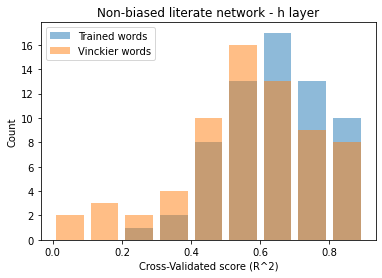

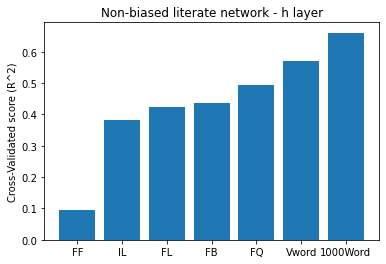

In [4]:
# Model fitting on words and testing on Vinckier stimuli
########  Units selective for words identified by Thomas
NBL = 1; # Non-biased literate network flag 
if NBL:
    wordSelUnit = [4,21,23,29,38,41,44,53,59,83,89,92,109,110,115,122,142,146,149,150,152,161,165,166,170, 
              194,197,203,204,210,215,222,226,229,231,232,237,246,250,251,252,254,265,270,282,291,293,294,
              308,315,318,323,351,362,367,372,377,392,407,410,426,430,436,442,451,483,487,507]
else:
    wordSelUnit = [53,122,165,294,464,465,466,470,471,472,474,476,478,480,481,482,483,484,485,486,487,489,490,
              491,493,494,498,499,501]

strlist = list(string.ascii_lowercase) # storing charaacters from A-Z

####################################### Vinckier stimuli  
data_dir = 'stimuli/vinckier50/'
chosen_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), transform[x]) for x in ['train']}
dataloaders = {x: torch.utils.data.DataLoader(chosen_datasets[x], batch_size = 400) for x in ['train']}
images, classes = next(iter(dataloaders['train']))

_,_,_,_,varh,_ = net(images.float())
Vli_obs = np.array(varh.detach().numpy())
Vli_obs = Vli_obs[:,wordSelUnit]

print('data loaded')

#### Loading stimuli and their properties
import glob, os, string
Vwordlist = []; nstimpercat = 50
for file in glob.glob("../others/StimulusProperties/*.txt"):
    if not file[-6:-4] == 'NV':
        file1 = open(file,"r") 
        x = (file1.read()).split('\n')
        Vwordlist = np.concatenate((Vwordlist, x[:nstimpercat]))

#  Building regression matrix
Vxmat = np.zeros((len(Vwordlist), 26*8))

# Assigning ones at corresponding locations      
for i, seq in enumerate(Vwordlist):
    for j, char in enumerate(seq.lower()): 
        if char in strlist:
            pid = (strlist.index(char)*8) + j # Encoding position information
#             pid = (strlist.index(char)) 
            Vxmat[i,pid] += 1 
            
########################################### Loading 1000 word stimuli
######## Loading datasets
stimword = np.transpose(np.tile(wordlist,(8, 1))).flatten()
x = np.array(nBli['h']) #stimulus 

# Setting up the parameters to perform PC
out = x[:,wordSelUnit]  # Analysing properties of individual word selective units

##### Building the regression matrix
Xmat = np.zeros((len(stimword), 26*8)) 

# Assigning ones at corresponding locations      
for i, seq in enumerate(stimword):
    for j, char in enumerate(seq): 
        if char in strlist:
            pid = (strlist.index(char)*8) + j
            Xmat[i,pid] += 1 

    
##### Initializing variables
rfit = np.zeros(len(wordSelUnit))
Vrfit = np.zeros((len(wordSelUnit), 6))
res = np.zeros((np.shape(out)))
Laic = np.zeros(len(wordSelUnit))
coefMat = np.zeros((len(wordSelUnit), 26*8))

##################################################### Model fitting
for npc in range(len(wordSelUnit)): 
    reg = LassoCV(cv=5, random_state=0,max_iter=10000).fit(Xmat, out[:,npc])   
    corrval,pval = scipy.stats.pearsonr(Xmat@reg.coef_, out[:,npc])
    res[:,npc] = Xmat@reg.coef_ - out[:,npc] 
    rfit[npc] = corrval**2
    coefMat[npc,:] = reg.coef_
    
    #   Calculating aicc value
    sse = np.sum((Xmat@reg.coef_ - out[:,npc])**2)
    nsam = np.size(out,0); npars = len(reg.coef_)
    Laic[npc] = nsam*np.log(sse/nsam) + (2*npars) + (2*npars*(npars+1)/(nsam-npars-1));
    
    for i in range(6):
        corrval,_ = scipy.stats.pearsonr(Vxmat[(i)*50:(i+1)*50,:]@reg.coef_, Vli_obs[(i)*50:(i+1)*50,npc])
        Vrfit[npc,i] = corrval**2 
     
    
plt.hist(rfit, bins= np.arange(0,1,.1), rwidth= .8, alpha = 0.5)
plt.hist(Vrfit[:,5],bins = np.arange(0,1,.1),alpha = 0.5, rwidth= .8)
plt.xlabel('Cross-Validated score (R^2)'); plt.ylabel('Count')
plt.title('Non-biased literate network - h layer')
plt.legend(['Trained words','Vinckier words'])

Ravg = np.append(np.nanmean(Vrfit,0),np.nanmean(rfit))
Rstd = np.append(np.nanstd(Vrfit,0),np.nanstd(rfit))
plt.figure(2); plt.bar(range(7),Ravg)
plt.errorbar(range(7),Ravg,Rstd, ecolor = 'k')
plt.ylabel('Cross-Validated score (R^2)')
plt.title('Non-biased literate network - h layer')
plt.xticks(ticks = range(7),labels=['FF','IL','FL','FB','FQ','Vword','1000Word']);
# plt.savefig("plots/figure10b.pdf")

# Statistical test 
from scipy import stats
for i in range(5):
    print(stats.ttest_rel(Vrfit[:,i],Vrfit[:,i+1]))
print(stats.ttest_rel(Vrfit[:,5],rfit[:]))

44
2
43
18
26
0
49
47
9
53
25
19
23
12


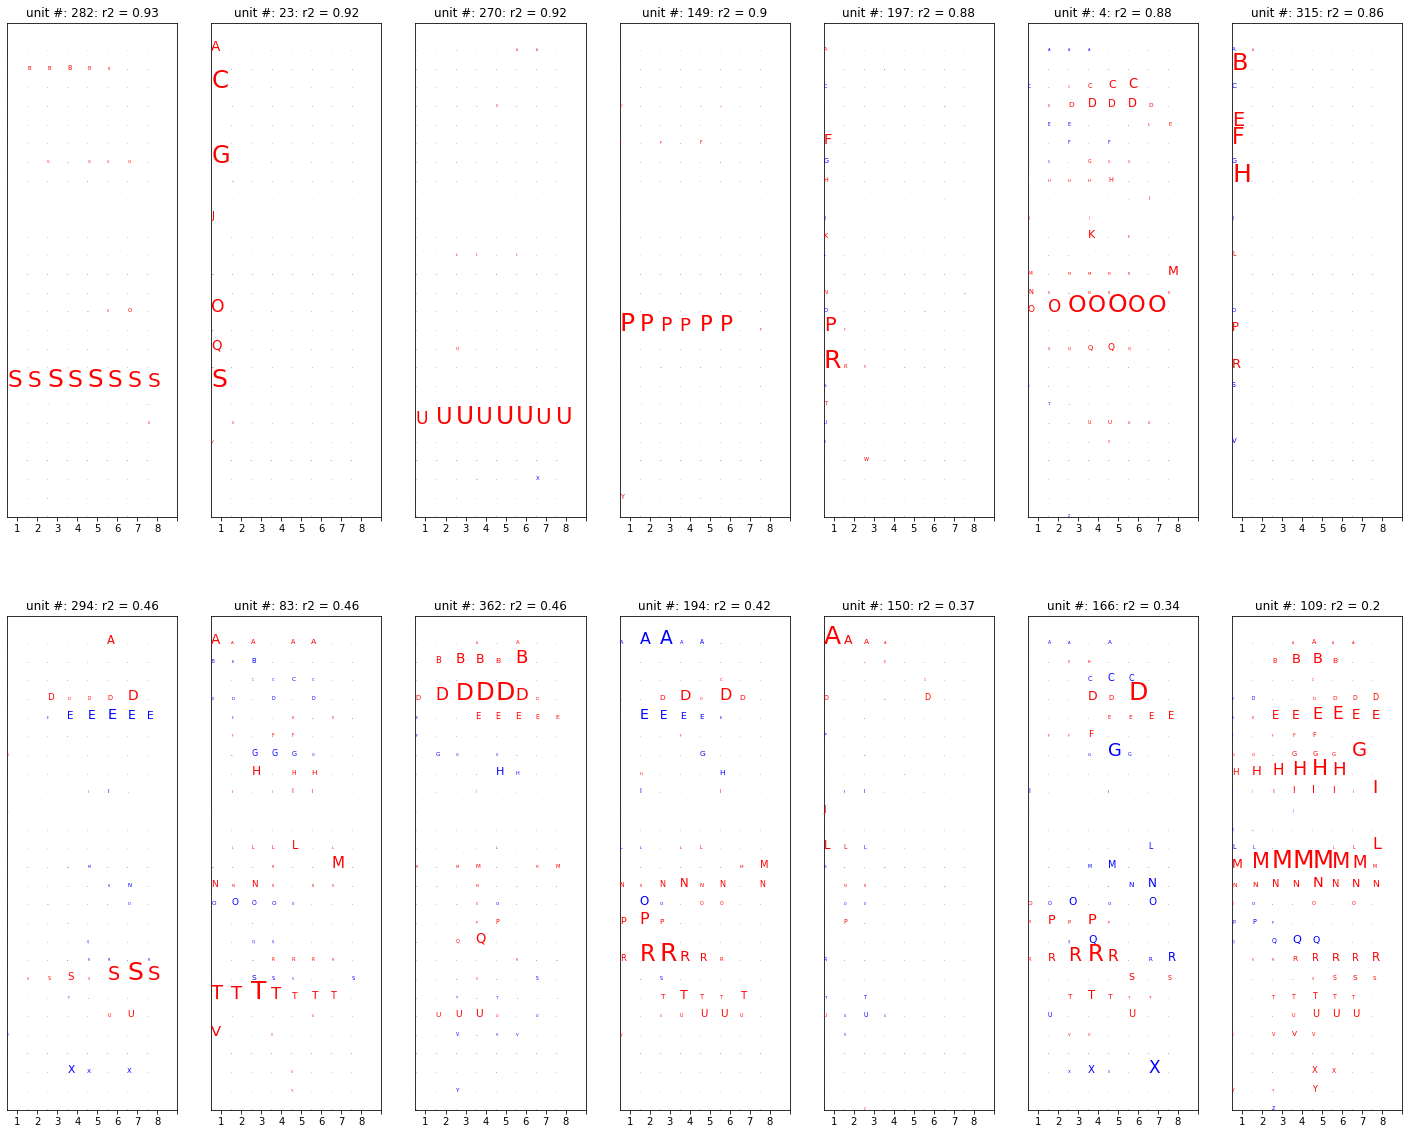

In [7]:
# plotting the receptive field

# Units selective for words identified by Thomas
NBL = 1; # Non-biased literate network flag 
if NBL:
    wordSelUnit = [4,21,23,29,38,41,44,53,59,83,89,92,109,110,115,122,142,146,149,150,152,161,165,166,170, 
              194,197,203,204,210,215,222,226,229,231,232,237,246,250,251,252,254,265,270,282,291,293,294,
              308,315,318,323,351,362,367,372,377,392,407,410,426,430,436,442,451,483,487,507]
else:
    wordSelUnit = [53,122,165,294,464,465,466,470,471,472,474,476,478,480,481,482,483,484,485,486,487,489,490,
              491,493,494,498,499,501]
    


sortid = np.argsort(-rfit) # Sorting in descending order
visid = np.r_[sortid[:7], sortid[-7:]]

# Initializing the variables
max_len = max(map(len, stimword)); 
fig, axs = plt.subplots(2,7, figsize=(25,20), facecolor='w', edgecolor='k')
axs = axs.ravel();
strlist = list(string.ascii_lowercase) # storing charaacters from A-Z


for i,val in enumerate(visid):
    print(val)
    # Visualizing the coefficients
    charcoef = np.reshape(coefMat[val,:],[26,8])
    maxval = np.max(abs(charcoef)); charcoef = charcoef*25/maxval
    for r in range(np.size(charcoef,0)):
        strchar = string.ascii_uppercase[r]
        for c in range(np.size(charcoef,1)):
            strcol = 'red' if charcoef[r,c] >0 else 'blue'
            axs[i].text( c,25-r, strchar, FontSize = abs(charcoef[r,c]), color = strcol)
            axs[i].set_xticks(np.arange(0.5,9,1)); axs[i].set_xticklabels(['1','2','3','4','5','6','7','8']);
            axs[i].set_yticks(np.arange(0.5,27,1)); axs[i].set_yticklabels([]);
            axs[i].yaxis.set_ticks_position('none') 


    axs[i].set_title('unit #: ' + str(wordSelUnit[val])+ ': r2 = '+str(round(rfit[val],2)))

plt.savefig("plots/letterRF_figure10.pdf")


data loaded


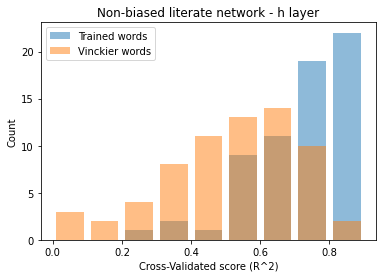

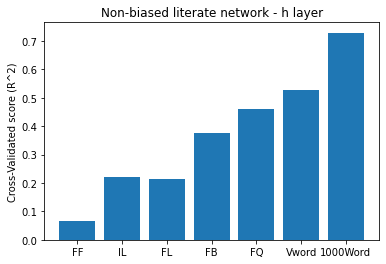

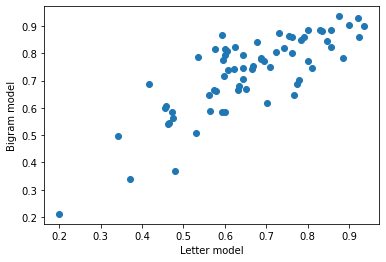

In [9]:
# Bigram model

NBL = 1; # Non-biased literate network flag 
if NBL:
    wordSelUnit = [4,21,23,29,38,41,44,53,59,83,89,92,109,110,115,122,142,146,149,150,152,161,165,166,170, 
              194,197,203,204,210,215,222,226,229,231,232,237,246,250,251,252,254,265,270,282,291,293,294,
              308,315,318,323,351,362,367,372,377,392,407,410,426,430,436,442,451,483,487,507]
else:
    wordSelUnit = [53,122,165,294,464,465,466,470,471,472,474,476,478,480,481,482,483,484,485,486,487,489,490,
              491,493,494,498,499,501]
    
bigrams = []
for lword in wordlist:
    for i in range(len(lword)-1):
        bigrams.append(lword[i:i+2])
        
bigramlist =  np.unique(bigrams); bigramlist = list(bigramlist[3:])        

##############################################Building the regression matrix
####################################### Vinckier stimuli  
data_dir = 'stimuli/vinckier50/'
chosen_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), transform[x]) for x in ['train']}
dataloaders = {x: torch.utils.data.DataLoader(chosen_datasets[x], batch_size = 400) for x in ['train']}
images, classes = next(iter(dataloaders['train']))

_,_,_,_,varh,_ = net(images.float())
Vli_obs = np.array(varh.detach().numpy())
Vli_obs = Vli_obs[:,wordSelUnit]

print('data loaded')

#### Loading stimuli and their properties
import glob, os, string
Vwordlist = []; nstimpercat = 50
for file in glob.glob("../others/StimulusProperties/*.txt"):
    if not file[-6:-4] == 'NV':
        file1 = open(file,"r") 
        x = (file1.read()).split('\n')
        Vwordlist = np.concatenate((Vwordlist, x[:nstimpercat]))

#  Building regression matrix
Vxmat = np.zeros((len(Vwordlist), len(bigramlist)))

# Assigning ones at corresponding locations      
for i, seq in enumerate(Vwordlist):
    for j in range(len(seq)-1): 
        char = seq.lower()[j:j+2]
        if char in bigramlist:
            pid = (bigramlist.index(char)) 
            Vxmat[i,pid] += 1 
            
########################################### Loading 1000 word stimuli
######## Loading datasets
stimword = np.transpose(np.tile(wordlist,(8, 1))).flatten()
x = np.array(nBli['h']) #stimulus 

# Setting up the parameters to perform PC
out = x[:,wordSelUnit]  # Analysing properties of individual word selective units

##### Building the regression matrix
Xmat = np.zeros((len(stimword), len(bigramlist))) 

# Assigning ones at corresponding locations      
for i, seq in enumerate(stimword):
    for j in range(len(seq)-1): 
        char = seq.lower()[j:j+2]
        if char in bigramlist:
            pid = (bigramlist.index(char)) 
            Xmat[i,pid] += 1 



##### Initializing variables
rfit1 = np.zeros(len(wordSelUnit))
BVrfit = np.zeros((len(wordSelUnit), 6))
bicoef = np.zeros((len(wordSelUnit), len(bigramlist)))
res = np.zeros((np.shape(out)))
Baic = np.zeros(len(wordSelUnit))

##################################################### Model fitting
for npc in range(len(wordSelUnit)): 
    reg = LassoCV(cv=5, random_state=0,max_iter=10000).fit(Xmat, out[:,npc])   
    corrval,_ = scipy.stats.pearsonr(Xmat@reg.coef_, out[:,npc])
    bicoef[npc,:] = reg.coef_
    rfit1[npc] = corrval**2
    res[:,npc] = Xmat@reg.coef_ - out[:,npc] 
    
#   Calculating aicc value
    sse = np.sum((Xmat@reg.coef_ - out[:,npc])**2)
    nsam = np.size(out,0); npars = len(reg.coef_)
    Baic[npc] = nsam*np.log(sse/nsam) + (2*npars) + (2*npars*(npars+1)/(nsam-npars-1));
    for i in range(6):
        corrval,_ = scipy.stats.pearsonr(Vxmat[(i)*50:(i+1)*50,:]@reg.coef_, Vli_obs[(i)*50:(i+1)*50,npc])
        BVrfit[npc,i] = corrval**2 
     
    
plt.hist(rfit1, bins= np.arange(0,1,.1), rwidth= .8, alpha = 0.5)
plt.hist(BVrfit[:,5],bins = np.arange(0,1,.1),alpha = 0.5, rwidth= .8)
plt.xlabel('Cross-Validated score (R^2)'); plt.ylabel('Count')
plt.title('Non-biased literate network - h layer')
plt.legend(['Trained words','Vinckier words'])

Ravg = np.append(np.nanmean(BVrfit,0),np.nanmean(rfit1))
plt.figure(2); plt.bar(range(7),Ravg)
plt.ylabel('Cross-Validated score (R^2)')
plt.title('Non-biased literate network - h layer')
plt.xticks(ticks = range(7),labels=['FF','IL','FL','FB','FQ','Vword','1000Word']);

plt.figure(3); plt.scatter(rfit,rfit1)
plt.xlabel('Letter model')
plt.ylabel('Bigram model')
idx= ~np.isnan(rfit) * ~np.isnan(rfit1)
rc,p = scipy.stats.pearsonr(rfit[idx],rfit1[idx])


44
2
43
18
26
0
49
47
9
53
25
19
23
12


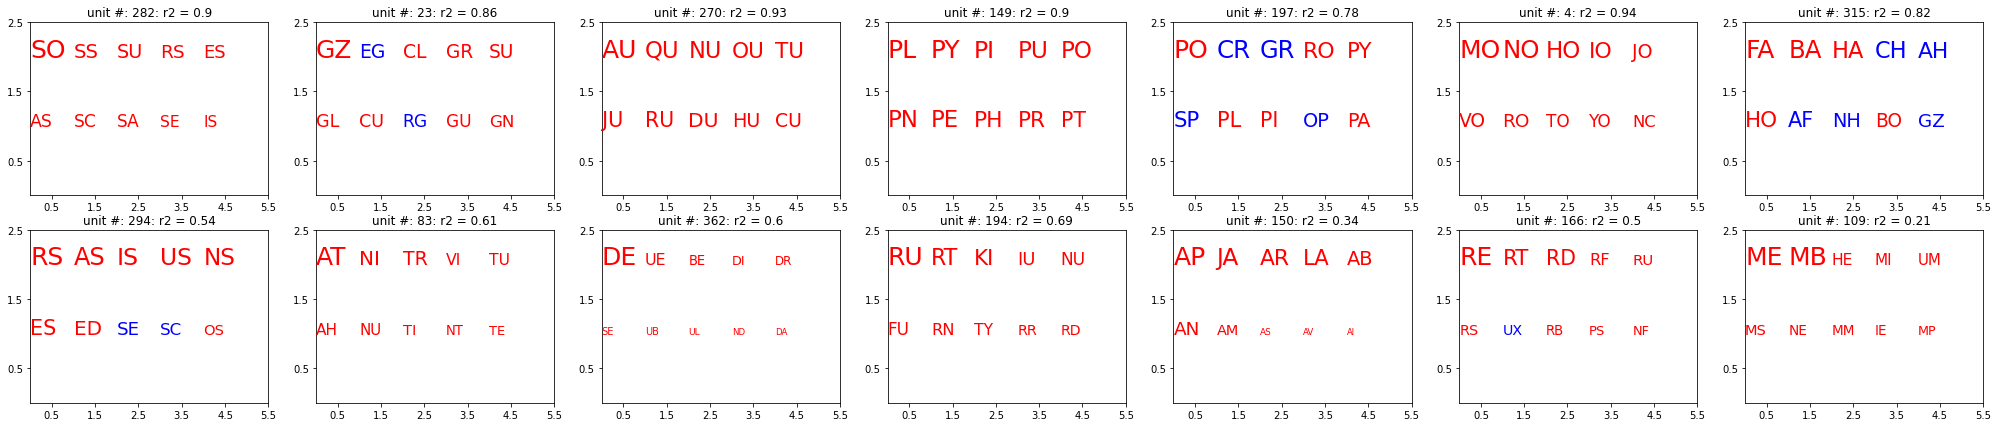

In [30]:
# Visualizing bigram coefficients for the selected 10 units from letter model
fig, axs = plt.subplots(2,7, figsize=(35,7), facecolor='w', edgecolor='k')
axs = axs.ravel();

bigramlist = np.array(bigramlist)
for i,val in enumerate(visid):
    print(val)
    # Visualizing the coefficients
    Coefval = bicoef[val,:]
    maxval = np.max(abs(Coefval)); Coefval = Coefval*25/maxval
    coefid = np.argsort(-np.abs(Coefval))
    
    cnt = 0
    for r in range(2):
        for c in range(5):
            strchar = (bigramlist[coefid[cnt]]).upper()
            strcol = 'red' if Coefval[coefid[cnt]] >0 else 'blue'
            axs[i].text( c,2-r, strchar, FontSize = abs(Coefval[coefid[cnt]]), color = strcol)
            axs[i].set_xticks(np.arange(0.5,6,1)); axs[i].set_yticks(np.arange(0.5,3,1)); 
            cnt = cnt+1
    
    
#     axs[i].bar(range(14), Coefval[coefid[:14]])
#     axs[i].set_xticks(range(14)); axs[i].set_xticklabels(bigramlist[coefid[:14]],rotation = 45);

#     maxval = np.max(abs(charcoef)); charcoef = charcoef*25/maxval
#     for r in range(np.size(charcoef,0)):
#         strchar = string.ascii_uppercase[r]
#         for c in range(np.size(charcoef,1)):
#             strcol = 'red' if charcoef[r,c] >0 else 'blue'
#             axs[i].text( c,25-r, strchar, FontSize = abs(charcoef[r,c]), color = strcol)
#             axs[i].set_xticks(np.arange(0.5,9,1)); axs[i].set_xticklabels(['1','2','3','4','5','6','7','8']);
#             axs[i].set_yticks(np.arange(0.5,27,1)); axs[i].set_yticklabels([]);
#             axs[i].yaxis.set_ticks_position('none') 


    axs[i].set_title('unit #: ' + str(wordSelUnit[val])+ ': r2 = '+str(round(rfit1[val],2)))
plt.savefig("plots/bigramRF_figure10.pdf")


data loaded


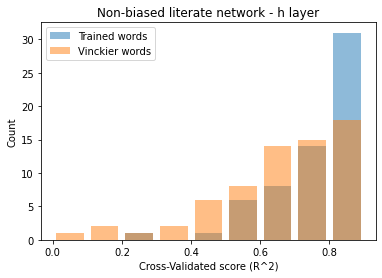

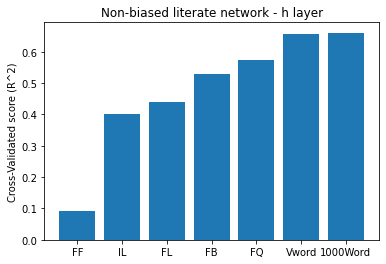

In [33]:
# Buidling a joint bigram and letter model
########  Units selective for words identified by Thomas
NBL = 1; # Non-biased literate network flag 
if NBL:
    wordSelUnit = [4,21,23,29,38,41,44,53,59,83,89,92,109,110,115,122,142,146,149,150,152,161,165,166,170, 
              194,197,203,204,210,215,222,226,229,231,232,237,246,250,251,252,254,265,270,282,291,293,294,
              308,315,318,323,351,362,367,372,377,392,407,410,426,430,436,442,451,483,487,507]
else:
    wordSelUnit = [53,122,165,294,464,465,466,470,471,472,474,476,478,480,481,482,483,484,485,486,487,489,490,
              491,493,494,498,499,501]

# Creating string and bigram list
strlist = list(string.ascii_lowercase) # storing charaacters from A-Z
bigrams = []
for lword in wordlist:
    for i in range(len(lword)-1):
        bigrams.append(lword[i:i+2])
        
bigramlist =  np.unique(bigrams); bigramlist = list(bigramlist[3:])     

####################################### Vinckier stimuli  
data_dir = 'stimuli/vinckier50/'
chosen_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), transform[x]) for x in ['train']}
dataloaders = {x: torch.utils.data.DataLoader(chosen_datasets[x], batch_size = 400) for x in ['train']}
images, classes = next(iter(dataloaders['train']))

_,_,_,_,varh,_ = net(images.float())
Vli_obs = np.array(varh.detach().numpy())
Vli_obs = Vli_obs[:,wordSelUnit]

print('data loaded')

#### Loading stimuli and their properties
import glob, os, string
Vwordlist = []; nstimpercat = 50
for file in glob.glob("../others/StimulusProperties/*.txt"):
    if not file[-6:-4] == 'NV':
        file1 = open(file,"r") 
        x = (file1.read()).split('\n')
        Vwordlist = np.concatenate((Vwordlist, x[:nstimpercat]))

#  Building regression matrix
Cxmat = np.zeros((len(Vwordlist), (26*8)+len(bigramlist)))

# Assigning ones at corresponding locations      
for i, seq in enumerate(Vwordlist):
    for j, char in enumerate(seq.lower()): 
        if char in strlist:
            pid = (strlist.index(char)*8) + j # Encoding position information
            Cxmat[i,pid] += 1 
    
    # Appending bigram data
    for j in range(len(seq)-1): 
        char = seq.lower()[j:j+2]
        if char in bigramlist:
            pid = (bigramlist.index(char)) 
            Cxmat[i,pid+(26*8)] += 1
            
    
########################################### Loading 1000 word stimuli
######## Loading datasets
stimword = np.transpose(np.tile(wordlist,(8, 1))).flatten()
x = np.array(nBli['h']) #stimulus 

# Setting up the parameters to perform PC
out = x[:,wordSelUnit]  # Analysing properties of individual word selective units

##### Building the regression matrix
Xmat = np.zeros((len(stimword), (26*8)+len(bigramlist))) 

# Assigning ones at corresponding locations      
for i, seq in enumerate(stimword):
    for j, char in enumerate(seq): 
        if char in strlist:
            pid = (strlist.index(char)*8) + j
            Xmat[i,pid] += 1 
    
    # Appending bigram data
    for j in range(len(seq)-1): 
        char = seq.lower()[j:j+2]
        if char in bigramlist:
            pid = (bigramlist.index(char)) 
            Xmat[i,pid+(26*8)] += 1 
    

##### Initializing variables
Crfit = np.zeros(len(wordSelUnit))
CVrfit = np.zeros((len(wordSelUnit), 6))
Caic = np.zeros(len(wordSelUnit))

##################################################### Model fitting
for npc in range(len(wordSelUnit)): 
    reg = LassoCV(cv=5, random_state=0,max_iter=10000).fit(Xmat, out[:,npc])   
    corrval,_ = scipy.stats.pearsonr(Xmat@reg.coef_, out[:,npc]); 
    Crfit[npc] = corrval**2
    
    for i in range(6):
        corrval,_ = scipy.stats.pearsonr(Cxmat[(i)*50:(i+1)*50,:]@reg.coef_, Vli_obs[(i)*50:(i+1)*50,npc])
        CVrfit[npc,i] = corrval**2 
     
    #   Calculating aicc value
    sse = np.sum((Xmat@reg.coef_ - out[:,npc])**2)
    nsam = np.size(out,0); npars = len(reg.coef_)
    Caic[npc] = nsam*np.log(sse/nsam) + (2*npars) + (2*npars*(npars+1)/(nsam-npars-1));

        
        
plt.hist(Crfit, bins= np.arange(0,1,.1), rwidth= .8, alpha = 0.5)
plt.hist(CVrfit[:,5],bins = np.arange(0,1,.1),alpha = 0.5, rwidth= .8)
plt.xlabel('Cross-Validated score (R^2)'); plt.ylabel('Count')
plt.title('Non-biased literate network - h layer')
plt.legend(['Trained words','Vinckier words'])

Ravg = np.append(np.nanmean(CVrfit,0),np.nanmean(rfit))
Rstd = np.append(np.nanstd(CVrfit,0),np.nanstd(rfit))
plt.figure(2); plt.bar(range(7),Ravg)
plt.errorbar(range(7),Ravg,Rstd, ecolor = 'k')
plt.ylabel('Cross-Validated score (R^2)')
plt.title('Non-biased literate network - h layer')
plt.xticks(ticks = range(7),labels=['FF','IL','FL','FB','FQ','Vword','1000Word']);
# plt.savefig("plots/figure10b.pdf")

# Statistical test 
from scipy import stats
for i in range(5):
    print(stats.ttest_rel(CVrfit[:,i],CVrfit[:,i+1]))
print(stats.ttest_rel(CVrfit[:,5],rfit[:]))

[26980.86105226 26413.64847697 24653.81507817]


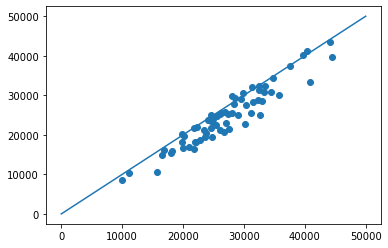

In [68]:
from scipy import stats
print(stats.ttest_rel(Baic, Caic))
print(np.mean([Laic,Baic,Caic],1))
plt.scatter(Laic, Caic);
plt.plot([0,50000],[0,50000])